# TRUMP ANAL

### TODO:
- clean up tokenizing
- check out bi-lstm
- predict current tweets
- individual validation
- @potus tweets

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import string
import gensim
import shutil

from io import StringIO
from keras import layers 
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dropout, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Flatten, Conv1D, GlobalMaxPooling1D, LSTM

MAX_WORDS = 15000

### Merge Embedding Files

In [41]:
if not os.path.exists("glove.6B.100d.txt"):
    with open("glove.6B.100d.txt", "w+") as output:
        for i in range(0,8):
            print("Writing embeddings_" + str(i))
            with open(".embeddings/embeddings_"+str(i)) as part:
                output.write("".join(part.readlines()))
    shutil.rmtree(".embeddings/")
    print("Embedding file created!")
else:
    print("Embedding file already exists!")
    
print("Done!")

Embedding file already exists!
Done!


### Prepare Labels

In [44]:
df = pd.read_json("trump_tweets_11_17.json") # read json
replacement_dict = {"Twitter for iPhone": 1, "Twitter for Android": 0}
df = df.replace(to_replace=replacement_dict)   # replace labels with 1s and 0s
df = df[df.source.apply(lambda x: type(x) == int)]  # remove tweets from other sources
df = df.sample(frac=1)

### Split into training and testing

In [45]:
all_texts = df.sample(frac=1, random_state=0) # random sampling with reproducibility

X_train, X_test, y_train, y_test = train_test_split(
    all_texts['text'], 
    all_texts['source'], 
    test_size=0.20, 
    random_state=42)

### Data analysis

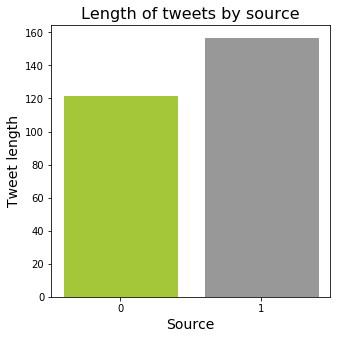

In [46]:
def length_vs_label(x,y):
    labels = np.unique(y)
    avgs = []
    for label in labels:
        avg = 0
        count = 0
        for text in x[y==label]:
            avg += len(text)
            count+=1
        avg /= count
        avgs.append(avg)
    
    plt.figure(figsize=(5,5))
    bars = plt.bar([str(label) for label in labels], avgs)
    bars[0].set_color('#a4c639') # android
    bars[1].set_color('#989898') # spacegray
    plt.title('Length of tweets by source', fontsize=16)
    plt.ylabel('Tweet length', fontsize=14)
    plt.xlabel('Source', fontsize=14)
    plt.show()
    
length_vs_label(X_train, y_train) # iPhone tweets longer than Android tweets on average

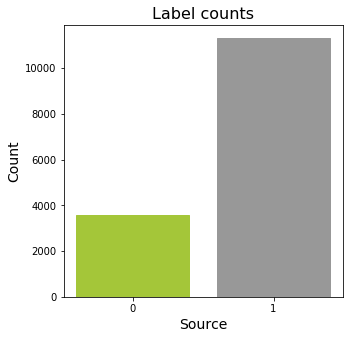

In [47]:
def label_counts(y):
    unique = np.unique(y_train, return_counts=True)
    
    plt.figure(figsize=(5,5))
    bars = plt.bar([str(u) for u in unique[0]], unique[1])
    bars[0].set_color('#a4c639') # android
    bars[1].set_color('#989898') # spacegray
    plt.title('Label counts', fontsize=16)
    plt.ylabel('Count', fontsize=14)
    plt.xlabel('Source', fontsize=14)
    plt.show()
    
label_counts(y_train) # more iPhone tweets than Android

### Tokenize Text for Embedding Layer

In [48]:
#create word-to-index dictionary
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# convert text to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# tokenizer dictionary
dictionary = tokenizer.word_index

In [49]:
#length of current dictionary vocab
vocab_size = len(tokenizer.word_index) + 1

maxlen = 65

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### construct embeddings using a glove model

In [50]:
embeddings_dictionary = dict()

#file is too large to store on git, must download and place in folder manually
glove_file = open('./glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [51]:
#create embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [52]:
vocab_size == len(embedding_matrix)

True

# Feed Forward Network

In [53]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [54]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 65, 100)           2444900   
_________________________________________________________________
flatten_3 (Flatten)          (None, 6500)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6501      
Total params: 2,451,401
Trainable params: 6,501
Non-trainable params: 2,444,900
_________________________________________________________________
None


In [55]:
ffn_history = model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)

Train on 11903 samples, validate on 2976 samples
Epoch 1/15
11903/11903 [==============================] - 0s 26us/step - loss: 0.4120 - acc: 0.7950 - val_loss: 0.3519 - val_acc: 0.8303
Epoch 2/15
11903/11903 [==============================] - 0s 21us/step - loss: 0.3208 - acc: 0.8463 - val_loss: 0.3292 - val_acc: 0.8269
Epoch 3/15
11903/11903 [==============================] - 0s 21us/step - loss: 0.2921 - acc: 0.8618 - val_loss: 0.3147 - val_acc: 0.8478
Epoch 4/15
11903/11903 [==============================] - 0s 23us/step - loss: 0.2746 - acc: 0.8729 - val_loss: 0.3103 - val_acc: 0.8474
Epoch 5/15
11903/11903 [==============================] - 0s 27us/step - loss: 0.2629 - acc: 0.8789 - val_loss: 0.3145 - val_acc: 0.8431
Epoch 6/15
11903/11903 [==============================] - 0s 24us/step - loss: 0.2533 - acc: 0.8852 - val_loss: 0.3076 - val_acc: 0.8508
Epoch 7/15
11903/11903 [==============================] - 0s 23us/step - loss: 0.2461 - acc: 0.8889 - val_loss: 0.3073 - val_acc:

In [56]:
ffn_score = model.evaluate(X_test, y_test, verbose=1)

3720/3720 [==============================] - 0s 33us/step


In [57]:
print("Test Score:", ffn_score[0])
print("Test Accuracy:", ffn_score[1])

Test Score: 0.3102992484646459
Test Accuracy: 0.850806474685669


### BALANCING

In [58]:
from keras.utils import to_categorical
from imblearn.keras import balanced_batch_generator
from imblearn.under_sampling import NearMiss

In [59]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [60]:
model_balance = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model_balance.add(embedding_layer)

model_balance.add(Flatten())
model_balance.add(Dense(2, activation='sigmoid'))

In [61]:
model_balance.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model_balance.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 65, 100)           2444900   
_________________________________________________________________
flatten_4 (Flatten)          (None, 6500)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 13002     
Total params: 2,457,902
Trainable params: 13,002
Non-trainable params: 2,444,900
_________________________________________________________________
None


In [62]:
training_generator, steps_per_epoch = balanced_batch_generator(X_train, y_train, sampler=NearMiss(), batch_size=128, random_state=42)

In [63]:
balanced_history_ffn = model_balance.fit_generator(generator=training_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
55/55 [==============================] - 0s 6ms/step - loss: 0.5334 - acc: 0.7346 - val_loss: 0.4999 - val_acc: 0.7372
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.4168 - acc: 0.8250 - val_loss: 0.4632 - val_acc: 0.7711
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.3741 - acc: 0.8476 - val_loss: 0.4489 - val_acc: 0.7840
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.3473 - acc: 0.8579 - val_loss: 0.4460 - val_acc: 0.7898
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.3322 - acc: 0.8644 - val_loss: 0.4478 - val_acc: 0.7933
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.3174 - acc: 0.8708 - val_loss: 0.4544 - val_acc: 0.7952
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.3060 - acc: 0.8752 - val_loss: 0.4660 - val_acc: 0.7945
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.2959 - acc: 0.88

In [64]:
model_balance.evaluate(X_test, y_test)

3720/3720 [==============================] - 0s 31us/step


[0.5382961806430612, 0.8158602118492126]

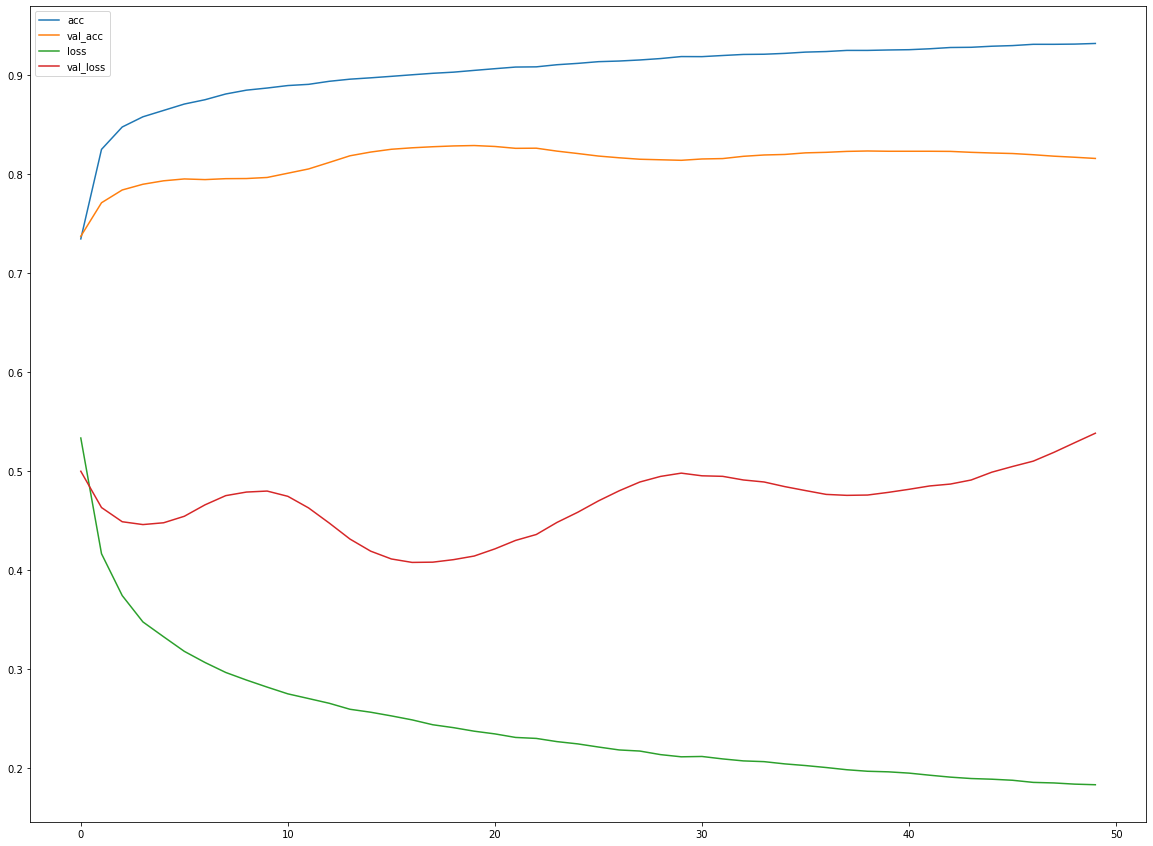

In [65]:
plt.figure(figsize=(20,15))
plt.plot(balanced_history_ffn.history['acc'])
plt.plot(balanced_history_ffn.history['val_acc'])
plt.plot(balanced_history_ffn.history['loss'])
plt.plot(balanced_history_ffn.history['val_loss'])
plt.legend(['acc','val_acc','loss','val_loss'])
plt.show()

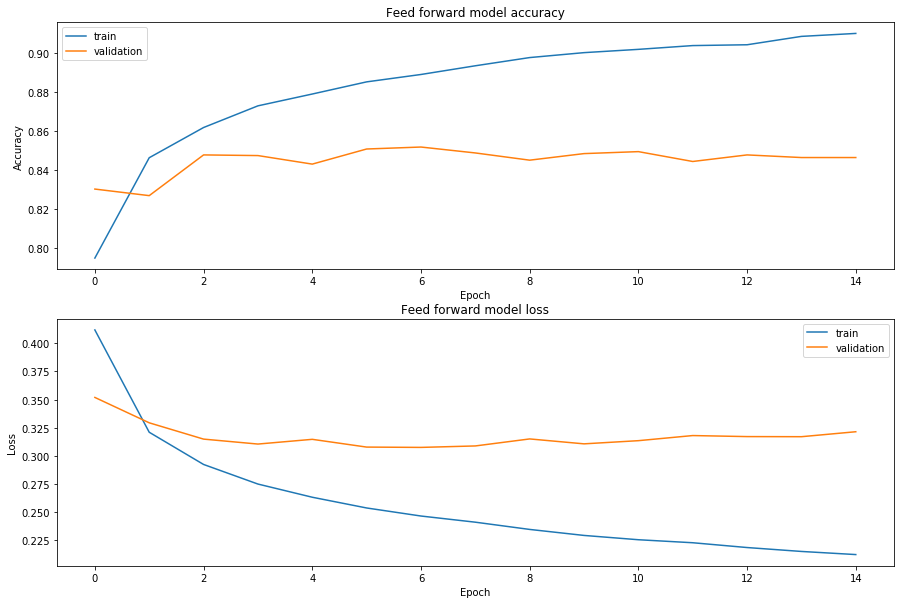

In [69]:
# plots
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(ffn_history.history['acc'])
plt.plot(ffn_history.history['val_acc'])
plt.title('Feed forward model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','validation'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(ffn_history.history['loss'])
plt.plot(ffn_history.history['val_loss'])
plt.title('Feed forward model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

# CNN

In [112]:
cnn = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn.add(embedding_layer)

cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(2, activation='sigmoid'))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [113]:
print(cnn.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 65, 100)           2444900   
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 61, 128)           64128     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 258       
Total params: 2,509,286
Trainable params: 64,386
Non-trainable params: 2,444,900
_________________________________________________________________
None


In [114]:
cnn_history = cnn.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)

cnn_score = cnn.evaluate(X_test, y_test, verbose=1)

Train on 11903 samples, validate on 2976 samples
Epoch 1/15
11903/11903 [==============================] - 3s 277us/step - loss: 0.4144 - acc: 0.8110 - val_loss: 0.3666 - val_acc: 0.8338
Epoch 2/15
11903/11903 [==============================] - 4s 300us/step - loss: 0.3047 - acc: 0.8663 - val_loss: 0.3371 - val_acc: 0.8395
Epoch 3/15
11903/11903 [==============================] - 3s 274us/step - loss: 0.2538 - acc: 0.8977 - val_loss: 0.3077 - val_acc: 0.8649
Epoch 4/15
11903/11903 [==============================] - 3s 253us/step - loss: 0.2163 - acc: 0.9145 - val_loss: 0.2968 - val_acc: 0.8690
Epoch 5/15
11903/11903 [==============================] - 3s 260us/step - loss: 0.1768 - acc: 0.9379 - val_loss: 0.2912 - val_acc: 0.8656
Epoch 6/15
11903/11903 [==============================] - 3s 273us/step - loss: 0.1476 - acc: 0.9542 - val_loss: 0.2982 - val_acc: 0.8646
Epoch 7/15
11903/11903 [==============================] - 3s 265us/step - loss: 0.1251 - acc: 0.9631 - val_loss: 0.2831 - v

In [115]:
print("Test Score:", cnn_score[0])
print("Test Accuracy:", cnn_score[1])

Test Score: 0.2916683505459498
Test Accuracy: 0.8885752558708191


### BALANCING CNN

In [118]:
cnn_balance = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_balance.add(embedding_layer)

cnn_balance.add(Conv1D(128, 5, activation='relu'))
cnn_balance.add(GlobalMaxPooling1D())
cnn_balance.add(Dense(2, activation='sigmoid'))
cnn_balance.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [119]:
cnn_balance.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(cnn_balance.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 65, 100)           2444900   
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 61, 128)           64128     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 258       
Total params: 2,509,286
Trainable params: 64,386
Non-trainable params: 2,444,900
_________________________________________________________________
None


In [120]:
training_generator, steps_per_epoch = balanced_batch_generator(X_train, y_train, sampler=NearMiss(), batch_size=128, random_state=42)

In [121]:
balanced_history_cnn = cnn_balance.fit_generator(generator=training_generator, steps_per_epoch=steps_per_epoch, epochs=40, verbose=1, validation_data=(X_test, y_test))

Epoch 1/40
55/55 [==============================] - 2s 38ms/step - loss: 0.4740 - acc: 0.7769 - val_loss: 0.7252 - val_acc: 0.5538
Epoch 2/40
55/55 [==============================] - 2s 35ms/step - loss: 0.3473 - acc: 0.8572 - val_loss: 0.7123 - val_acc: 0.6144
Epoch 3/40
55/55 [==============================] - 2s 36ms/step - loss: 0.2854 - acc: 0.8871 - val_loss: 0.7022 - val_acc: 0.6312
Epoch 4/40
55/55 [==============================] - 2s 37ms/step - loss: 0.2428 - acc: 0.9071 - val_loss: 0.6437 - val_acc: 0.6624
Epoch 5/40
55/55 [==============================] - 2s 34ms/step - loss: 0.2102 - acc: 0.9221 - val_loss: 0.5900 - val_acc: 0.6922
Epoch 6/40
55/55 [==============================] - 2s 40ms/step - loss: 0.1793 - acc: 0.9364 - val_loss: 0.5960 - val_acc: 0.6978
Epoch 7/40
55/55 [==============================] - 2s 37ms/step - loss: 0.1526 - acc: 0.9517 - val_loss: 0.6746 - val_acc: 0.6749
Epoch 8/40
55/55 [==============================] - 2s 34ms/step - loss: 0.1292 - a

In [122]:
cnn_balance.evaluate(X_test, y_test)

3720/3720 [==============================] - 0s 120us/step


[1.2754622310720465, 0.6754032373428345]

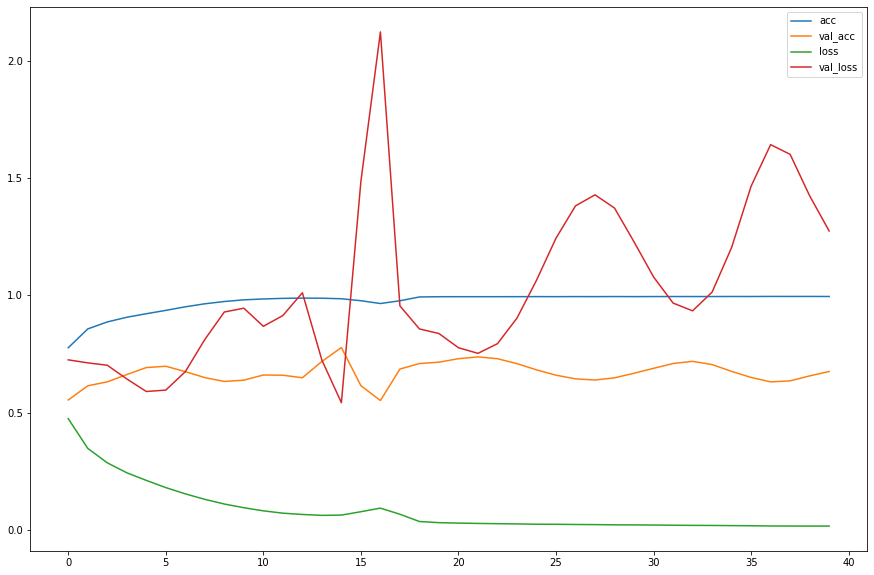

In [123]:
plt.figure(figsize=(15,10))
plt.plot(balanced_history_cnn.history['acc'])
plt.plot(balanced_history_cnn.history['val_acc'])
plt.plot(balanced_history_cnn.history['loss'])
plt.plot(balanced_history_cnn.history['val_loss'])
plt.legend(['acc','val_acc','loss','val_loss'])
plt.show()

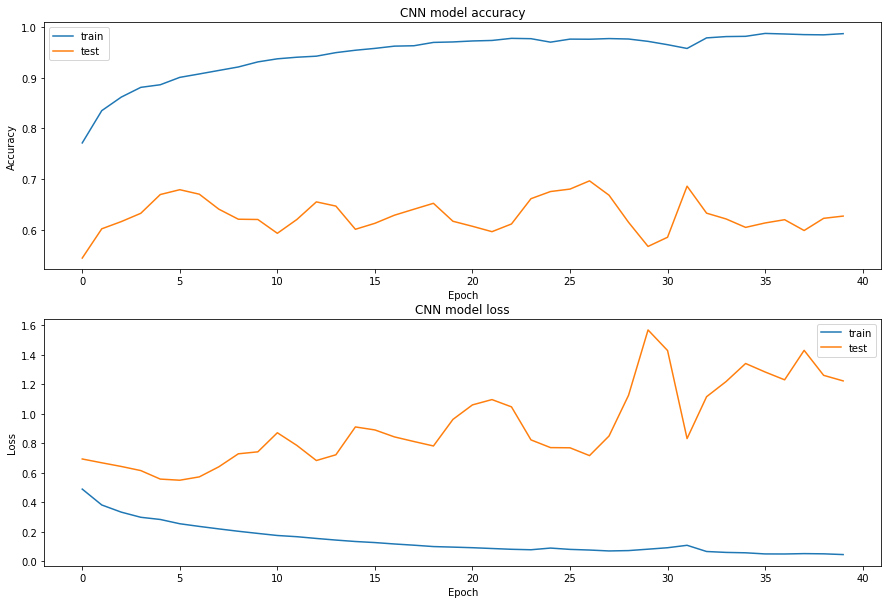

In [110]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(balanced_history_cnn.history['acc'])
plt.plot(balanced_history_cnn.history['val_acc'])
plt.title('CNN model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc = 'upper left')

plt.subplot(2,1,2)
plt.plot(balanced_history_cnn.history['loss'])
plt.plot(balanced_history_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc = 'upper right')
plt.show()

# LSTM model

In [101]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(2, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [102]:
print(lstm_model.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 65, 100)           2444900   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 258       
Total params: 2,562,406
Trainable params: 117,506
Non-trainable params: 2,444,900
_________________________________________________________________
None


In [103]:
lstm_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)

lstm_score = lstm_model.evaluate(X_test, y_test, verbose=1)

Train on 11903 samples, validate on 2976 samples
Epoch 1/15
11903/11903 [==============================] - 13s 1ms/step - loss: 0.5022 - acc: 0.7625 - val_loss: 0.4226 - val_acc: 0.7745
Epoch 2/15
11903/11903 [==============================] - 13s 1ms/step - loss: 0.3702 - acc: 0.8214 - val_loss: 0.3332 - val_acc: 0.8370
Epoch 3/15
11903/11903 [==============================] - 14s 1ms/step - loss: 0.3166 - acc: 0.8414 - val_loss: 0.3195 - val_acc: 0.8464
Epoch 4/15
11903/11903 [==============================] - 13s 1ms/step - loss: 0.2937 - acc: 0.8565 - val_loss: 0.2976 - val_acc: 0.8634
Epoch 5/15
11903/11903 [==============================] - 13s 1ms/step - loss: 0.2834 - acc: 0.8670 - val_loss: 0.2900 - val_acc: 0.8624
Epoch 6/15
11903/11903 [==============================] - 13s 1ms/step - loss: 0.2751 - acc: 0.8713 - val_loss: 0.2849 - val_acc: 0.8695
Epoch 7/15
11903/11903 [==============================] - 12s 1ms/step - loss: 0.2680 - acc: 0.8767 - val_loss: 0.2866 - val_acc:

In [104]:
print("Test Score:", lstm_score[0])
print("Test Accuracy:", lstm_score[1])

Test Score: 0.26304805359692984
Test Accuracy: 0.8935483694076538


### BALANCE

In [105]:
lstm_model_balance = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model_balance.add(embedding_layer)
lstm_model_balance.add(LSTM(128))

lstm_model_balance.add(Dense(2, activation='sigmoid'))
lstm_model_balance.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [106]:
balanced_history_lstm = lstm_model_balance.fit_generator(generator=training_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
55/55 [==============================] - 9s 156ms/step - loss: 0.5665 - acc: 0.7265 - val_loss: 0.6551 - val_acc: 0.5637
Epoch 2/50
55/55 [==============================] - 8s 142ms/step - loss: 0.4336 - acc: 0.8129 - val_loss: 0.6763 - val_acc: 0.6124
Epoch 3/50
55/55 [==============================] - 8s 139ms/step - loss: 0.3777 - acc: 0.8394 - val_loss: 0.7310 - val_acc: 0.5808
Epoch 4/50
55/55 [==============================] - 8s 137ms/step - loss: 0.3653 - acc: 0.8493 - val_loss: 0.6279 - val_acc: 0.6341
Epoch 5/50
55/55 [==============================] - 8s 138ms/step - loss: 0.3623 - acc: 0.8556 - val_loss: 0.7309 - val_acc: 0.6191
Epoch 6/50
55/55 [==============================] - 8s 138ms/step - loss: 0.3492 - acc: 0.8551 - val_loss: 0.6930 - val_acc: 0.5903
Epoch 7/50
55/55 [==============================] - 8s 138ms/step - loss: 0.3279 - acc: 0.8654 - val_loss: 0.5284 - val_acc: 0.6993
Epoch 8/50
55/55 [==============================] - 8s 143ms/step - loss: 0.

In [116]:
lstm_model_balance.evaluate(X_test, y_test)

3720/3720 [==============================] - 2s 574us/step


[0.9892270750896905, 0.7471774220466614]

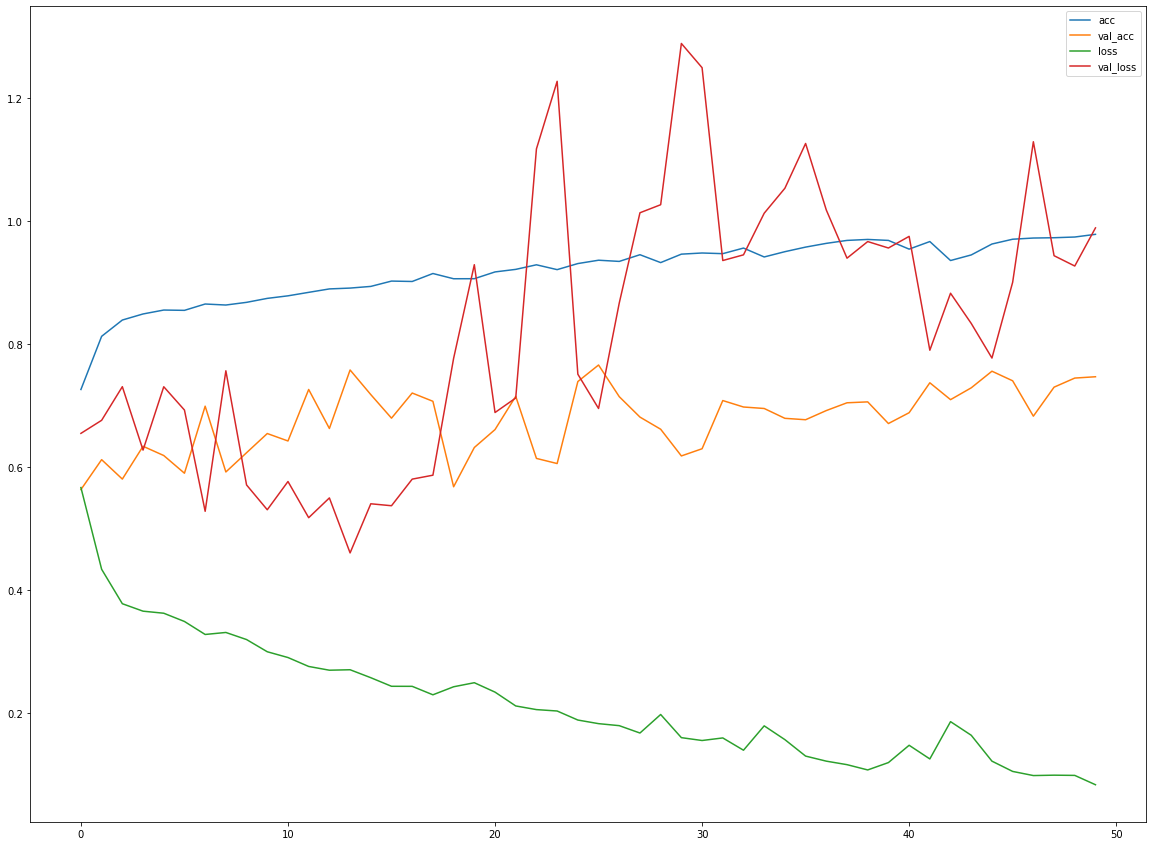

In [117]:
plt.figure(figsize=(20,15))
plt.plot(balanced_history_lstm.history['acc'])
plt.plot(balanced_history_lstm.history['val_acc'])
plt.plot(balanced_history_lstm.history['loss'])
plt.plot(balanced_history_lstm.history['val_loss'])
plt.legend(['acc','val_acc','loss','val_loss'])
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(lstm_history.history['acc'])
plt.plot(lstm_history.history['val_acc'])
plt.title('LSTM model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
lstm_model.predict(X_test)[2]